# Data wrangling

Add imports

In [1]:
import os
import pandas as pd
import re

Read raw output .csv's from obtained by crawling. Add new columns `Search word` and `Most watched`

In [3]:
folder_path = "../outputs/"
dataframes = []
pattern = r"(.+?)(?:_(most_watched))?\.csv"

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):

        match = re.search(pattern, filename)
        if match:
            word = match.group(1)
            most_watched = match.group(2) is not None
            file_path = os.path.join(folder_path, filename)
            file_df = pd.read_csv(file_path)
            file_df["Search word"] = word
            file_df["Most watched"] = most_watched
            dataframes.append(file_df)

df = pd.concat(dataframes, ignore_index=True)
df.head()

,Video Id,Title,View Count,Length,Channel,Search word,Most watched
0,ssFgYNn0BUA,Mallrat - Groceries (Official Video),2 900 865 katselukertaa,3.35,/channel/UCK2codDA94XHf66dbfSy6vw,groceries,False
1,34djOMgVq-0,Pi'erre Bourne - Groceries (Official Music Video),1 644 500 katselukertaa,4.10,/channel/UCN27za3wzItmyRV2O3N91vw,groceries,False
2,ha4tRQwKIUg,I Bought Everything In A Store - Challenge,144 516 730 katselukertaa,16.56,/@MrBeast,groceries,False
3,8oZNzedMhUo,"Roommate WON'T BUY Groceries, What Happens Is ...",20 756 555 katselukertaa,8.14,/@DharMann,groceries,False
4,WClN_VrYosc,HOW WE WENT BROKE GROCERY SHOPPING FOR FOOD **...,721 509 katselukertaa,40.56,/@TheOfficialPrinceFamily,groceries,False


Remove NaN's and create new column `Views` as type `int`

In [4]:
df.dropna(subset=["View Count", "Length"], inplace=True)
df["Views"] = df["View Count"].str.extract("(\d+(?:\s\d+)*)").replace(r"\s+", "", regex=True).fillna("0").astype(int)
df.describe()

,Views
count,7.374190e+05
mean,5.084356e+07
std,2.158456e+08
min,0.000000e+00
25%,2.085415e+05
50%,3.095021e+06
75%,2.633310e+07
max,1.335517e+10


Change `Search word` and `Most watched` types

In [5]:
df["Search word"] = df["Search word"].apply(lambda x: [x])
df["Most watched"] = df["Most watched"].map({True: "Y", False: "N"})
df.head()

,Video Id,Title,View Count,Length,Channel,Search word,Most watched,Views
0,ssFgYNn0BUA,Mallrat - Groceries (Official Video),2 900 865 katselukertaa,3.35,/channel/UCK2codDA94XHf66dbfSy6vw,[groceries],N,2900865
1,34djOMgVq-0,Pi'erre Bourne - Groceries (Official Music Video),1 644 500 katselukertaa,4.10,/channel/UCN27za3wzItmyRV2O3N91vw,[groceries],N,1644500
2,ha4tRQwKIUg,I Bought Everything In A Store - Challenge,144 516 730 katselukertaa,16.56,/@MrBeast,[groceries],N,144516730
3,8oZNzedMhUo,"Roommate WON'T BUY Groceries, What Happens Is ...",20 756 555 katselukertaa,8.14,/@DharMann,[groceries],N,20756555
4,WClN_VrYosc,HOW WE WENT BROKE GROCERY SHOPPING FOR FOOD **...,721 509 katselukertaa,40.56,/@TheOfficialPrinceFamily,[groceries],N,721509


Group by `Video Id` and aggregate `Search words` and `Most watched` information

In [6]:
def append_words(series):
    return list(set([item for sublist in series for item in sublist]))

def append_search_type(series):
    return set(series)

aggregations = {
    "Title": "first",
    "Views": "first",
    "Length": "first",
    "Channel": "first",
    "Search word": append_words,
    "Most watched": append_search_type
}

df = df.groupby("Video Id").agg(aggregations).reset_index()

Convert `Most watched` into three categorial values: ```Y = Most watched | N = Normal | B = Both```

In [7]:
def convert_most_watched(values):
    if values == {"N", "Y"}:
        return "B"
    elif "Y" in values:
        return "Y"
    else:
        return "N"

df["Most watched"] = df["Most watched"].apply(convert_most_watched).astype("category")

Result checking head and tail

In [8]:
df.head()

,Video Id,Title,Views,Length,Channel,Search word,Most watched
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,8867396,0.27,/@bastarfiles,[dist],Y
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,144,26.55,/@FXPesa,[pulse],N
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,798201,0.59,/@bekifaayati,[discounted],Y
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),424,4.13,/@maxchet,[conversely],N
4,--14w5SOEUs,Migos - Avalanche (Official Video),21229658,3.59,/channel/UC9YcTIQuhwgoOQqYMKYqW9A,[avalanche],Y


In [9]:
df.tail()

,Video Id,Title,Views,Length,Channel,Search word,Most watched
524554,zzwWzLY7kEo,NewJeans (뉴진스) 'ETA' Dance Practice,3131516,2.39,/channel/UCMki_UkHb4qSc0qyEcOHHJw,[eta],N
524555,zzwXTkQ9n0k,Latest trend with Horse chestnut #asmr #oddlys...,68243230,0.19,/@hoofmaestro1130,[chestnut],Y
524556,zzwmEo-mzDc,Meryl - La Brume ft. Le Motif,5000660,3.13,/@MERYLytchn,[motif],Y
524557,zzyDz6jhX30,All I Ever Need - Austin Mahone (Lyrics),13613316,3.34,/@SuperbLyricsOfficial,[necessity],Y
524558,zzzIpC39WUg,How To Calculate Speeds and Feeds (Inch Versio...,267679,14.26,/@haasautomation,[feeds],N


# EDA

Display videos without views.

In [10]:
zero_views = df[df['Views'] == 0]
display(zero_views)

,Video Id,Title,Views,Length,Channel,Search word,Most watched
11297,0OcrOLPi2DY,"Recent Jazz Vinyl Finds #7 - Tons of grails, B...",0,37.35,/@amanandhismusic,[mccoy],N
14206,0kR1d1maUqM,Basisschool Het Christal in Vlaardingen (LEV-WN),0,1.26,/@LEV-ScholengroepWest-Nederland,[wn],N
25938,2APJAThtBzE,FF7 Ever Crisis Pulls for Aerith's Sunny Robe!,0,13.43,/@lad1174,[robe],N
28380,2Twncb3dE_o,BROKEN TO BEAST the Ultimate Warrior Overland ...,0,13.00,/@WolfPacOutdoors,[overland],N
30499,2jQyYTCkIXU,terminals specification viewpicture end italia...,0,1.41,/@phillipsandie6581,[viewpicture],Y
...,...,...,...,...,...,...,...
514039,yhFsW8RBwRE,NEW THIRD GEN!!! (IT BLEW UP ONLY HAD IR FOR T...,0,10.15,/@FBody_Addicts,[blew],N
515532,ysnYuGZG-zE,How to Whip Whipy Whip Whipping Cream Perfectl...,0,5.04,/@VillageKitchenGarden,[whipping],N
517375,z6WSeB7fMoo,Personally Speaking ep. 172 (Billy Keenan),0,28.00,/@PersonallySpeakingwithMsgrJimL,[personally],N
518265,zDQH7Yo0Um0,Eriette of the Charmed Apple $40 BUDGET EDH De...,0,9.51,/@GatheringTheMagicYT,[charmed],N


Remove music videos and filter non latin character containing titles.

In [11]:
words = ["vevo", "lyric", "music", "song", "official video", "mix", "remix" "album", "feat", "instrumental", "ft."]

def filter_words(title):
  low_title = title.lower()
  for w in words:
    if w in low_title:
      return False
  return True

filtered_df = df[df["Title"].apply(filter_words) & df["Channel"].apply(filter_words)]



In [12]:

print("unfiltered df: ", df.shape)
print("filtered df: ", filtered_df.shape)
print(f"row diff: -{df.shape[0] - filtered_df.shape[0]}\nlost {100 - round(filtered_df.shape[0] / df.shape[0] * 100)}% of rows")
display(filtered_df)

# -18% for just music words, -26% for music words AND # symbol

unfiltered df:  (524559, 7)
filtered df:  (443694, 7)
row diff: -80865
lost 15% of rows


,Video Id,Title,Views,Length,Channel,Search word,Most watched
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,8867396,0.27,/@bastarfiles,[dist],Y
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,144,26.55,/@FXPesa,[pulse],N
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,798201,0.59,/@bekifaayati,[discounted],Y
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),424,4.13,/@maxchet,[conversely],N
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,5143,1.29,/@AndrewRemillard,[firmly],N
...,...,...,...,...,...,...,...
524552,zzwRbKI2pn4,YALGAAR - CARRYMINATI X Wily Frenzy,350657873,3.15,/@CarryMinati,"[younger, frenzy, carry]",Y
524553,zzwUH3vbNkc,Klassendiagramme mit UML - Theoretische Objekt...,286980,7.32,/@simpleclub_informatik,[uml],Y
524554,zzwWzLY7kEo,NewJeans (뉴진스) 'ETA' Dance Practice,3131516,2.39,/channel/UCMki_UkHb4qSc0qyEcOHHJw,[eta],N
524555,zzwXTkQ9n0k,Latest trend with Horse chestnut #asmr #oddlys...,68243230,0.19,/@hoofmaestro1130,[chestnut],Y


### Create new column for original titles. Stopwords, punctuations, non-latin words, stemming and capital word counting

Create new column for original titles

In [15]:
filtered_df = filtered_df.copy()
filtered_df.insert(filtered_df.columns.get_loc("Title"), "Original Title", filtered_df["Title"])


Remove punctuations

In [16]:
filtered_df["Title"] = filtered_df["Title"].str.replace(r"[^\w\s]+", "", regex=True)
filtered_df.head()

,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,8867396,0.27,/@bastarfiles,[dist],Y
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,Fed Will Likely Hike in September Market Puls...,144,26.55,/@FXPesa,[pulse],N
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,Hyundai i20 at 25 Discount,798201,0.59,/@bekifaayati,[discounted],Y
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),PSY GANGNAM STYLE CONVERSELY,424,4.13,/@maxchet,[conversely],N
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,Firmly I Believe and Truly God is Three Halton...,5143,1.29,/@AndrewRemillard,[firmly],N


Remove non-latin words and words with numbers etc.

In [17]:
filtered_df["Title"] = filtered_df["Title"].str.replace(r"\b(?![a-zA-Z]+\b)\w+\b", "", regex=True)
display(filtered_df)

,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,8867396,0.27,/@bastarfiles,[dist],Y
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,Fed Will Likely Hike in September Market Puls...,144,26.55,/@FXPesa,[pulse],N
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,Hyundai at Discount,798201,0.59,/@bekifaayati,[discounted],Y
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),PSY GANGNAM STYLE CONVERSELY,424,4.13,/@maxchet,[conversely],N
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,Firmly I Believe and Truly God is Three Halton...,5143,1.29,/@AndrewRemillard,[firmly],N
...,...,...,...,...,...,...,...,...
524552,zzwRbKI2pn4,YALGAAR - CARRYMINATI X Wily Frenzy,YALGAAR CARRYMINATI X Wily Frenzy,350657873,3.15,/@CarryMinati,"[younger, frenzy, carry]",Y
524553,zzwUH3vbNkc,Klassendiagramme mit UML - Theoretische Objekt...,Klassendiagramme mit UML Theoretische Objekto...,286980,7.32,/@simpleclub_informatik,[uml],Y
524554,zzwWzLY7kEo,NewJeans (뉴진스) 'ETA' Dance Practice,NewJeans ETA Dance Practice,3131516,2.39,/channel/UCMki_UkHb4qSc0qyEcOHHJw,[eta],N
524555,zzwXTkQ9n0k,Latest trend with Horse chestnut #asmr #oddlys...,Latest trend with Horse chestnut asmr oddlysat...,68243230,0.19,/@hoofmaestro1130,[chestnut],Y


Check and remove if there are empty Title's due above operation and remove from the list (ie. fully non-latin titles etc.)

In [18]:
#Store length before operation
filtered_df_length = len(filtered_df)

# Used to see what kind of Original Title's belongs to this category
non_latin_df = filtered_df[filtered_df["Title"] == ""]

# Do the filtering
filtered_df = filtered_df[filtered_df["Title"] != ""]

print(f"Former length: {filtered_df_length} | New length: {len(filtered_df)} | Non-latins removed: {len(non_latin_df)} ({len(non_latin_df) / filtered_df_length * 100:1f}%)")
non_latin_df.head()


Former length: 443694 | New length: 443015 | Non-latins removed: 679 (0.153033%)


,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched
2438,-ILcH66zGcY,Lamp「恋人へ」(2004),,4969535,33.35,/@Orbisu,"[lamp, lamps]",N
3131,-NtjNCM0Kn4,君が泣くなら,,513417,4.58,/channel/UC4YXkw5kGqh8b_LD0fZrznw,[lamp],N
4319,-X4WFWWibIw,Nasraná,,238824,2.37,/channel/UCHMH6u_tYWwiwXUTv7q3scw,[ee],N
4707,-_Kb_H6eQpE,gamefaqs.m2t,,6785,0.12,/@GoEatATowel,[gamefaqs],N
5388,-eHasNIG4a4,Provócame,,1843122,3.01,/channel/UCt3FfEVsTlaKnJRGAsB7gZQ,[vallarta],Y


Save uppercased word count, lower case word count and words that start with capital character e.g 'Cat'.

In [19]:
def word_counts(row):
  sentence = row['Original Title']
  uppercase_pattern = r'\b(?:[A-Z]+\d*|[A-Z]*\d+[A-Z]+)[A-Z0-9]*\b'
  lowercase_pattern = r'\b(?:[a-z]+\d*|[a-z]*\d+[a-z]+)[a-z0-9]*\b'
  capital_pattern = r'\b[A-Z][a-z0-9]*\b'
  word_count_pattern = r'\w+'

  uppercase_count = len(re.findall(uppercase_pattern, sentence))
  lowercase_count = len(re.findall(lowercase_pattern, sentence))
  capital_count = len(re.findall(capital_pattern, sentence))
  word_count = len(re.findall(word_count_pattern, sentence))
  return pd.Series({'Uppercase Words': uppercase_count, 'Lowercase Words': lowercase_count, 'Capitalized Words': capital_count, 'Word Count': word_count})

filtered_df[['Uppercase Words', 'Lowercase Words', 'Capitalized Words', 'Word Count']] = filtered_df.apply(word_counts, axis = 1)

display(filtered_df)


,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched,Uppercase Words,Lowercase Words,Capitalized Words,Word Count
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,8867396,0.27,/@bastarfiles,[dist],Y,0,0,13,13
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,Fed Will Likely Hike in September Market Puls...,144,26.55,/@FXPesa,[pulse],N,0,2,9,11
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,Hyundai at Discount,798201,0.59,/@bekifaayati,[discounted],Y,0,2,2,5
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),PSY GANGNAM STYLE CONVERSELY,424,4.13,/@maxchet,[conversely],N,4,0,0,4
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,Firmly I Believe and Truly God is Three Halton...,5143,1.29,/@AndrewRemillard,[firmly],N,1,2,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...
524552,zzwRbKI2pn4,YALGAAR - CARRYMINATI X Wily Frenzy,YALGAAR CARRYMINATI X Wily Frenzy,350657873,3.15,/@CarryMinati,"[younger, frenzy, carry]",Y,3,0,3,5
524553,zzwUH3vbNkc,Klassendiagramme mit UML - Theoretische Objekt...,Klassendiagramme mit UML Theoretische Objekto...,286980,7.32,/@simpleclub_informatik,[uml],Y,1,1,4,7
524554,zzwWzLY7kEo,NewJeans (뉴진스) 'ETA' Dance Practice,NewJeans ETA Dance Practice,3131516,2.39,/channel/UCMki_UkHb4qSc0qyEcOHHJw,[eta],N,1,0,2,5
524555,zzwXTkQ9n0k,Latest trend with Horse chestnut #asmr #oddlys...,Latest trend with Horse chestnut asmr oddlysat...,68243230,0.19,/@hoofmaestro1130,[chestnut],Y,0,7,2,9


Change to lowercase and remove stop words

In [20]:
filtered_df["Title"] = filtered_df["Title"].str.lower()

with open("stop.txt") as f:
    stopwords = set(f.read().split("\n"))

filtered_df["Title"] = filtered_df["Title"].apply(lambda x: " ".join([word for word in str(x).split() if word not in (stopwords)]))
filtered_df.head()


,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched,Uppercase Words,Lowercase Words,Capitalized Words,Word Count
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,dharmesh yalande sir dance bastar dist chhatti...,8867396,0.27,/@bastarfiles,[dist],Y,0,0,13,13
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,fed hike september market pulse rufas kamau,144,26.55,/@FXPesa,[pulse],N,0,2,9,11
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,hyundai discount,798201,0.59,/@bekifaayati,[discounted],Y,0,2,2,5
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),psy gangnam style conversely,424,4.13,/@maxchet,[conversely],N,4,0,0,4
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,firmly god halton holgate,5143,1.29,/@AndrewRemillard,[firmly],N,1,2,8,10


Add stemming

In [21]:
from nltk.stem.porter import *

ps = PorterStemmer()
filtered_df["Title"] = filtered_df["Title"].apply(lambda x: ' '.join([ps.stem(word) for word in str(x).split()]))
display(filtered_df)

,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched,Uppercase Words,Lowercase Words,Capitalized Words,Word Count
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,dharmesh yaland sir danc bastar dist chhattisg...,8867396,0.27,/@bastarfiles,[dist],Y,0,0,13,13
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,fed hike septemb market puls rufa kamau,144,26.55,/@FXPesa,[pulse],N,0,2,9,11
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,hyundai discount,798201,0.59,/@bekifaayati,[discounted],Y,0,2,2,5
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),psi gangnam style convers,424,4.13,/@maxchet,[conversely],N,4,0,0,4
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,firmli god halton holgat,5143,1.29,/@AndrewRemillard,[firmly],N,1,2,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...
524552,zzwRbKI2pn4,YALGAAR - CARRYMINATI X Wily Frenzy,yalgaar carryminati wili frenzi,350657873,3.15,/@CarryMinati,"[younger, frenzy, carry]",Y,3,0,3,5
524553,zzwUH3vbNkc,Klassendiagramme mit UML - Theoretische Objekt...,klassendiagramm mit uml theoretisch objektorie...,286980,7.32,/@simpleclub_informatik,[uml],Y,1,1,4,7
524554,zzwWzLY7kEo,NewJeans (뉴진스) 'ETA' Dance Practice,newjean eta danc practic,3131516,2.39,/channel/UCMki_UkHb4qSc0qyEcOHHJw,[eta],N,1,0,2,5
524555,zzwXTkQ9n0k,Latest trend with Horse chestnut #asmr #oddlys...,trend hors chestnut asmr oddlysatisfi tiktok f...,68243230,0.19,/@hoofmaestro1130,[chestnut],Y,0,7,2,9


Make a copy from the new filtered dataframe

In [2]:
cleaned_df = filtered_df.copy()

NameError: name 'filtered_df' is not defined

### Store wrangled dataframe into outputs

In [1]:
cleaned_df.to_csv("wrangled_data.csv", index=False)

NameError: name 'cleaned_df' is not defined

### Plotting

Importing matplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



Testing...

In [ ]:
test_df = cleaned_df.copy()

test_df["Uppercase Words"] = test_df["Uppercase Words"] / test_df["Word Count"]
test_df["Lowercase Words"] = test_df["Lowercase Words"] / test_df["Word Count"]
test_df["Capitalized Words"] = test_df["Capitalized Words"] / test_df["Word Count"]

test_df.head()

,Video Id,Original Title,Title,Views,Length,Channel,Search word,Most watched,Uppercase Words,Lowercase Words,Capitalized Words,Word Count
0,---AKxmFRWI,Dharmesh Yalande Sir Dance Bastar Dist Chhatti...,dharmesh yaland sir danc bastar dist chhattisg...,8867396,0.27,/@bastarfiles,[dist],Y,0.0,0.000000,1.000000,13
1,---jp8dVvkY,Fed Will Likely Hike in September - Market Pul...,fed hike septemb market puls rufa kamau,144,26.55,/@FXPesa,[pulse],N,0.0,0.181818,0.818182,11
2,--0HXqi8xTk,Hyundai i20 at 25% Discount,hyundai discount,798201,0.59,/@bekifaayati,[discounted],Y,0.0,0.400000,0.400000,5
3,--0Qq5EmpGg,PSY - GANGNAM STYLE (CONVERSELY),psi gangnam style convers,424,4.13,/@maxchet,[conversely],N,1.0,0.000000,0.000000,4
5,--1bxl5E-u8,Firmly I Believe and Truly God is Three (Halto...,firmli god halton holgat,5143,1.29,/@AndrewRemillard,[firmly],N,0.1,0.200000,0.800000,10


Plotting word count with views.

(442903, 12)


<Axes: >

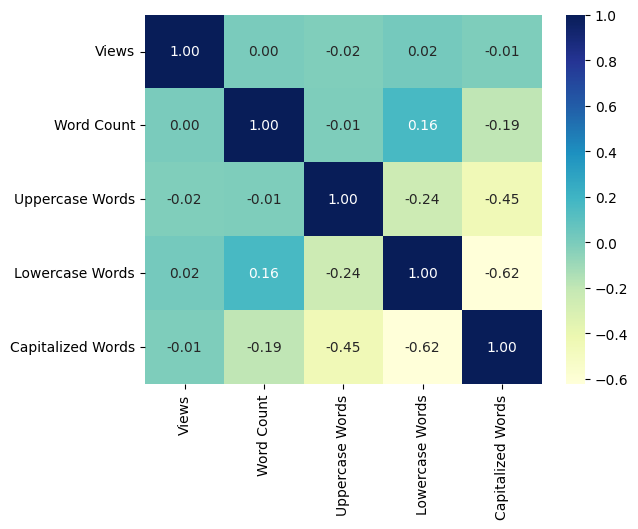

In [ ]:
videos_with_views = test_df[test_df['Views'] > 0]

print(videos_with_views.shape)

columns_test = videos_with_views[['Views','Word Count', 'Uppercase Words', 'Lowercase Words', 'Capitalized Words']]


sns.heatmap(columns_test.corr(), cmap = "YlGnBu", annot=True, fmt=".2f")



In [ ]:

print("Median views total: ", videos_with_views["Views"].median())
print("Average/mean views total: ", videos_with_views["Views"].mean())

d = {}

TEST_LINES = 100000

for _, row in videos_with_views.iterrows():
  TEST_LINES -= 1
  if TEST_LINES == 0:
    break
  for w in row.Title.split():
    if w in d:
      t = d[w]
      d[w] = (t[0] + row["Views"], t[1] + 1)
    else:
      d[w] = (row["Views"], 1)

# print(d)

d2 = {}

sum_of_averages = 0

for key, val in d.items():
  ave = val[0] / val[1]
  d2[key] = ave
  sum_of_averages += ave

# print(d2)

ave_views_per_word = sum_of_averages / len(d2)
print("Average/mean of average/mean views per word", ave_views_per_word)


sorted_d2 = dict(sorted(d2.items(), key=lambda item: item[1], reverse=True))

# print(sorted_d2)



Median views total:  907441.0
Average/mean views total:  14778846.95348643
Average/mean of average/mean views per word 15074867.833849838


In [ ]:

n = 10

sorted_d2_list = list(sorted_d2.items())

print(f"Highest {n} ave views words\n")
for i in range(n):
  print(sorted_d2_list[i])

print("\n\n")

print(f"Lowest {n} ave views words\n")
for i in range(n):
  print(sorted_d2_list[len(sorted_d2_list) - i - 1])


Highest 10 ave views words

('bicicleta', 1616768813.0)
('gaj', 1559330576.0)
('daman', 1559330576.0)
('jaji', 1559330576.0)
('renuka', 1559330576.0)
('queijo', 1514677059.0)
('zaroori', 1502617277.0)
('pillowtalk', 1181301044.0)
('amarelinho', 1167446448.0)
('gangnam', 1024099927.8)



Lowest 10 ave views words

('llwl', 1.0)
('firstgov', 1.0)
('heimdal', 1.0)
('shivamsingh', 1.0)
('myoneth', 2.0)
('ivtool', 3.0)
('dhonijadeja', 3.0)
('psilocyben', 3.0)
('microdos', 3.0)
('jelsoft', 3.6666666666666665)


In [ ]:
import numpy as np

# d3 is hashmap of words with key=word, value=(average_views, z-index)
# z-index is the mesurment of how much the value(average_views) deviates form the norm. The closer to zero the more average it is
d3 = {}

standard_deviation = np.std(videos_with_views["Views"])

for key, val in d2.items():
  z_index = (val - ave_views_per_word) / standard_deviation
  d3[key] = (val, z_index)


sorted_d3 = dict(sorted(d3.items(), key=lambda item: item[1], reverse=True))




In [ ]:
sorted_d3_list = list(sorted_d3.items())

print(f"Highest {n} ave views words\n")
for i in range(n):
  print(sorted_d3_list[i])

print("\n\n")

print(f"Lowest {n} ave views words\n")
for i in range(n):
  print(sorted_d3_list[len(sorted_d2_list) - i - 1])

Highest 10 ave views words

('bicicleta', (1616768813.0, 28.151895568284083))
('gaj', (1559330576.0, 27.142342367105805))
('daman', (1559330576.0, 27.142342367105805))
('jaji', (1559330576.0, 27.142342367105805))
('renuka', (1559330576.0, 27.142342367105805))
('queijo', (1514677059.0, 26.357497577541345))
('zaroori', (1502617277.0, 26.14553091283309))
('pillowtalk', (1181301044.0, 20.49797192498158))
('amarelinho', (1167446448.0, 20.254459023587483))
('gangnam', (1024099927.8, 17.734953796683037))



Lowest 10 ave views words

('llwl', (1.0, -0.264960779862539))
('firstgov', (1.0, -0.264960779862539))
('heimdal', (1.0, -0.264960779862539))
('shivamsingh', (1.0, -0.264960779862539))
('myoneth', (2.0, -0.2649607622862126))
('ivtool', (3.0, -0.26496074470988623))
('dhonijadeja', (3.0, -0.26496074470988623))
('psilocyben', (3.0, -0.26496074470988623))
('microdos', (3.0, -0.26496074470988623))
('jelsoft', (3.6666666666666665, -0.2649607329923353))
